In [1]:
%config IPCompleter.use_jedi = False
import pandas as pd
import warnings 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from pathlib import Path

In [2]:
proj_path = str(Path().resolve().parent)

In [3]:
FONT_NAME = 'Arial'
FONT_SIZE = 15
import matplotlib as mpl
mpl.rc('font',family='Arial')

In [4]:
file_2d = proj_path + "/results/density2D_64_128.csv" 
file_ts = proj_path + "/results/densityTS_64_128.csv"
file_large = proj_path + "/results/large2D_64_128.csv"
file_largeTS = proj_path + "/results/largeTS_64_128.csv"
file_batchTS = proj_path + "/results/batchTS_64_128.csv"
file_scalabilityTS = proj_path + "/results/scalabilityTS_64_128.csv"

In [5]:
df_2d_column_names = ['FF', 'FFD-Avg', 'FFD-Max',
       'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum', 'BFD-Avg', 'BFD-Max',
       'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum', 'BCD-L2Norm', 'BCD-DotProduct',
       'FFD-Degree', 'NodeCount', 'BCD-Fitness']

df_2d_large_column_names = ['FF', 'FFD-Avg', 'FFD-Max',
       'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum', 'BFD-Avg', 'BFD-Max',
       'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum', 'BCD-DotProduct',
       'FFD-Degree', 'BCD-Fitness']

df_ts_column_names = ['FF', 'FFD-Avg', 'FFD-Max',
       'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum', 'BFD-Avg', 'BFD-Max',
       'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum']

df_ts_large_column_names = ['FF', 'FFD-Avg', 'BFD-Avg', 'FFD-Degree']


df_scalab_column_names = ['FF', 'FFD-Avg', 'BFD-Avg', 'FFD-Degree']

df_batch_column_names = ['FF', 'FFD-Avg', 'BFD-Avg', 'BCD-DotProduct',
                         'FFD-Degree', 'BCD-Fitness']

classes = ['arbitrary', 'normal', 'threshold']

rename_dict = {
    "BCD-L2Norm": "NCD-L2Norm",
    "BCD-DotProduct": "NCD-DotProduct",
    "FFD-Degree": "Medea-TP",
    "NodeCount": "Medea-NC",
    "BCD-Fitness": "LRASched-Fitness"
}

In [6]:
## sub_df = any one in df_2d, df_ts, df_large
def get_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[0])
    #sub_df['density'] = sub_df['instance_name'].apply(lambda x: x.split('_')[1])
    sub_df['idx'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[2]))
    sub_df['density'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[1][1:]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = round(sub_df[i]/sub_df['LB'] - 1, 3)
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    sub_df_grouped_avg = sub_df.groupby(by = ['class', 'density'], as_index=False).mean()
    eps_df = sub_df_grouped_avg[['class', 'density'] + epsilon_column_names]
    time_df = sub_df_grouped_avg[['class', 'density'] + time_column_names]
    return eps_df, time_df

In [7]:
## sub_df = any one in df_2d, df_ts, df_large
def get_scale_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[3])
    sub_df['LRAnum'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[2]))
    sub_df['idx'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[-1]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = round(sub_df[i]/sub_df['LB'] - 1, 3)
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    sub_df_grouped_avg = sub_df.groupby(by = ['class', 'LRAnum'], as_index=False).mean()
    sub_df_grouped_avg_eps = sub_df_grouped_avg[['class', 'LRAnum'] + epsilon_column_names]
    sub_df_grouped_avg_time = sub_df_grouped_avg[['class', 'LRAnum'] + time_column_names]
    return sub_df_grouped_avg_eps, sub_df_grouped_avg_time

In [96]:
def plot_barchart(original_df, class_name, cols, xlabel, ylabel, log_scale=False):
    tmp_df = original_df[original_df['class'] == class_name][cols]
    tmp_df.rename(columns=rename_dict, errors='ignore', inplace=True)
    # group of densities/scale
    width = 0.1
    labels = original_df.density.apply(lambda x: f'{x:,}').unique()
    x = np.arange(len(labels))

    fig = plt.figure(figsize=(15, 5))
    algs = list(tmp_df.T.index)
    alg_num = len(tmp_df.T)
    alg_res = tmp_df.T.values

    width_class = width * alg_num + 0.2
    #width = 0.95/float(alg_num) # 0.06
    
    curr = alg_num/2.0 + 0.5 #int(alg_num/2)+1
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*', '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

    for i in range(alg_num):
        curr = curr - 1
        plt.bar(x*width_class - width*curr, alg_res[i], width, hatch = hatches[i], alpha=.99)
    
    plt.xticks(x*width_class, labels, fontsize=FONT_SIZE)#,fontweight='bold')
    plt.yticks(fontsize=FONT_SIZE)#, fontweight='bold')
    plt.xlabel(xlabel, fontname=FONT_NAME, fontsize=FONT_SIZE+2)#, fontweight='bold')
    plt.ylabel(ylabel, fontname=FONT_NAME, fontsize=FONT_SIZE+2)#, fontweight='bold')
    if log_scale:
        plt.yscale('log')
    #plt.legend(algs, loc='upper left', bbox_to_anchor=(-0.07, -0.2), ncol=5, fancybox=True, shadow=False, fontsize=FONT_SIZE)
    plt.legend(algs, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=5, fontsize=FONT_SIZE)
    plt.tight_layout()
    plt.show()
    return fig

# Result-1: 2D Fixed Res Request

## 1.1 Impact of Affinity Density On Effectiveness and Time Consumption

In [9]:
df_2d = pd.read_csv(file_2d, sep='\t')
twodim_eps, twodim_time = get_exp_results(df_2d, df_2d_column_names)
twodim_eps.columns = ['class', 'density'] + df_2d_column_names
twodim_time.columns = ['class', 'density'] + df_2d_column_names

#### The algorithm effectivenss and time consumption of the three different classes 

In [10]:
twodim_eps[twodim_eps['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,BFD-AvgExpo,BFD-Surrogate,BFD-ExtendedSum,BCD-L2Norm,BCD-DotProduct,FFD-Degree,NodeCount,BCD-Fitness
0,arbitrary,1,0.1222,0.1222,0.1222,0.1222,0.1222,0.1555,0.1222,0.1222,0.1225,0.1222,0.1555,0.1206,0.1164,0.1220,0.1224,0.1164
1,arbitrary,5,0.1216,0.1216,0.1216,0.1216,0.1216,0.1552,0.1216,0.1216,0.1214,0.1216,0.1552,0.1194,0.1147,0.1229,0.1261,0.1147
2,arbitrary,10,0.1206,0.1206,0.1206,0.1206,0.1206,0.1561,0.1206,0.1206,0.1202,0.1206,0.1561,0.1178,0.1138,0.1209,0.1293,0.1138


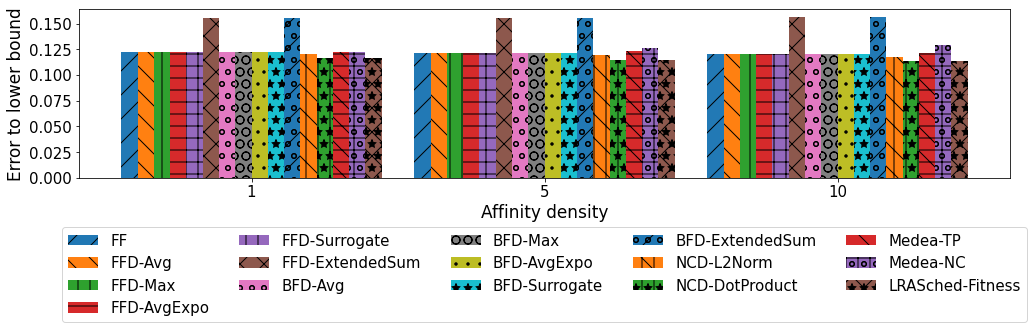

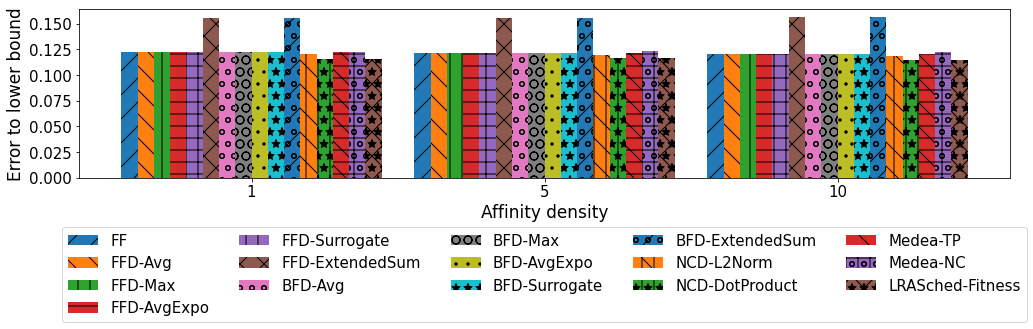

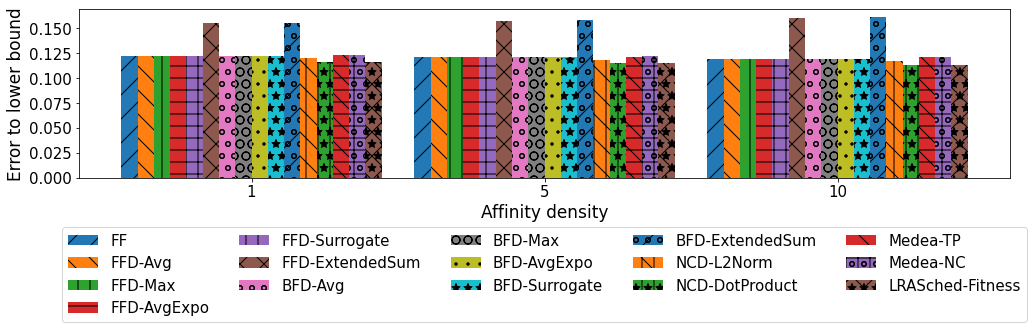

In [109]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(twodim_eps, c, df_2d_column_names, "Affinity density", 'Error to lower bound')
    filename = f"{proj_path}/plots/density2D_result_{c}.pdf" 
    fig.savefig(filename)

In [12]:
#for c in classes: 
#    plot_density_barchart(twodim_time, c, df_2d_column_names, 'Time consumption (s)')

If removing the time consumption of NodeCount:

In [13]:
time_cols_without_nodecount = df_2d_column_names.copy()
time_cols_without_nodecount.remove("NodeCount")

In [14]:
twodim_time[twodim_time['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,BFD-AvgExpo,BFD-Surrogate,BFD-ExtendedSum,BCD-L2Norm,BCD-DotProduct,FFD-Degree,NodeCount,BCD-Fitness
0,arbitrary,1,3.7710,3.7612,3.7497,3.7556,3.6853,4.4438,4.4945,4.5377,4.8137,4.5533,6.5212,26.0402,15.5378,3.6753,512.47660,19.8710
1,arbitrary,5,15.4295,15.5006,15.4409,15.3067,15.2997,16.7269,16.3147,16.3450,16.7146,16.3084,19.1326,44.8129,32.9146,15.5769,3200.63542,39.8085
2,arbitrary,10,29.6222,29.7348,29.5849,29.6681,29.4302,31.5974,30.3983,30.3682,30.5476,30.3118,33.8830,68.2773,55.9722,29.7318,8005.25371,66.7727


In [15]:
twodim_time[twodim_time['class'] == 'threshold'].sort_values(by='density')

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,BFD-AvgExpo,BFD-Surrogate,BFD-ExtendedSum,BCD-L2Norm,BCD-DotProduct,FFD-Degree,NodeCount,BCD-Fitness
6,threshold,1,3.3671,3.3610,3.3290,3.3264,3.3340,3.8047,3.9409,3.9594,4.2804,3.9666,5.3911,23.4764,12.8049,4.4504,138.34020,16.1640
7,threshold,5,14.6810,14.6825,14.6371,14.5415,14.6351,15.4408,15.3301,15.3568,15.6678,15.3708,17.3721,40.0816,28.7318,29.4328,1394.42151,34.3852
8,threshold,10,29.7038,29.7905,29.9800,29.9238,29.8791,31.2625,30.9095,30.5489,30.9935,30.7706,33.2675,62.0397,51.3667,85.9905,4929.91557,59.4702


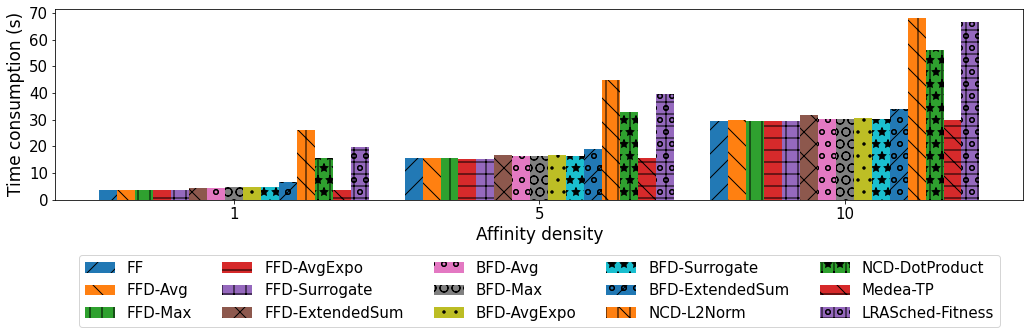

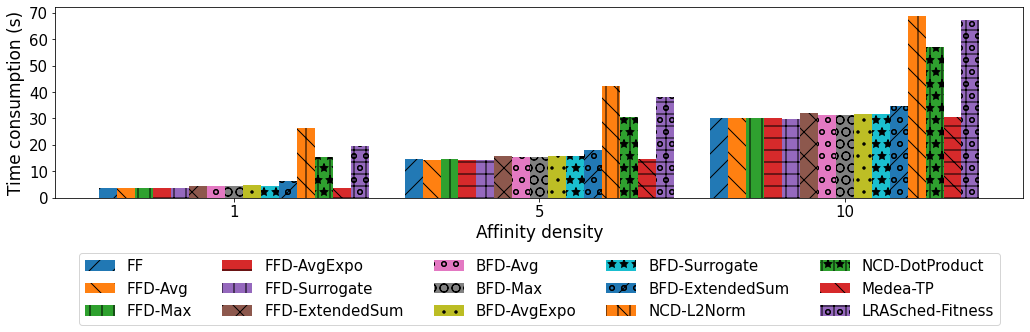

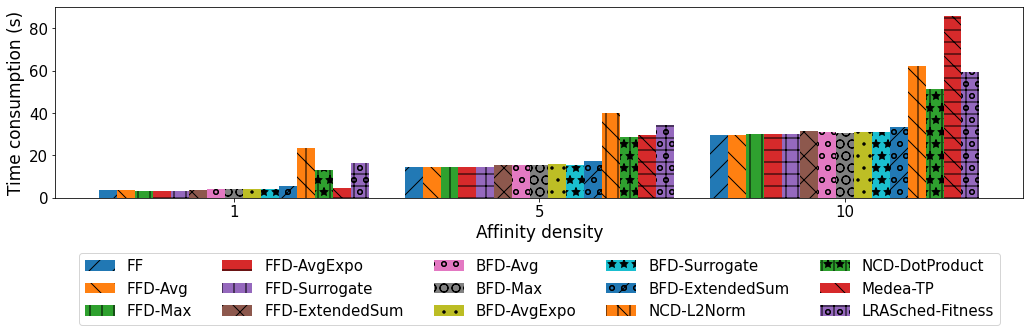

In [98]:
for c in classes: 
    #c = "arbitrary"
    fig = plot_barchart(twodim_time, c, time_cols_without_nodecount, "Affinity density", 'Time consumption (s)')

    filename = f"{proj_path}/plots/density2D_time_{c}.pdf"
    fig.savefig(filename)

## 1.2 Impact of LRA Submission Scale on Effectiveness and Time Consumption 

In [17]:
df_large = pd.read_csv(file_large, sep='\t') ## df_2d_large

twodim_eps_scale, twodim_time_scale = get_scale_exp_results(df_large, df_2d_large_column_names)
twodim_eps_scale.columns = ['class', 'density'] + df_2d_large_column_names
twodim_time_scale.columns = ['class', 'density'] + df_2d_large_column_names

In [18]:
twodim_eps_scale[twodim_eps_scale['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,BFD-AvgExpo,BFD-Surrogate,BFD-ExtendedSum,BCD-DotProduct,FFD-Degree,BCD-Fitness
0,arbitrary,10000,0.0270,0.0270,0.0270,0.0270,0.0270,0.0339,0.0270,0.0270,0.0270,0.0270,0.0339,0.0260,0.0274,0.0260
1,arbitrary,50000,0.0243,0.0243,0.0243,0.0243,0.0243,0.0381,0.0243,0.0243,0.0244,0.0243,0.0381,0.0234,0.0241,0.0234
2,arbitrary,100000,0.0240,0.0240,0.0240,0.0240,0.0240,0.0378,0.0240,0.0240,0.0241,0.0240,0.0378,0.0232,0.0240,0.0232


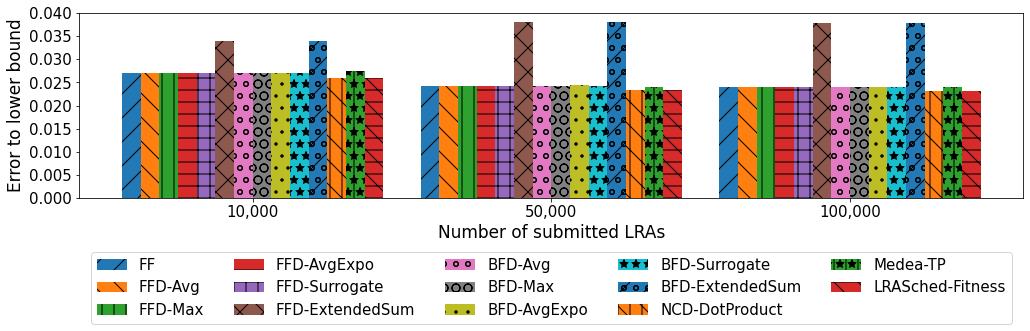

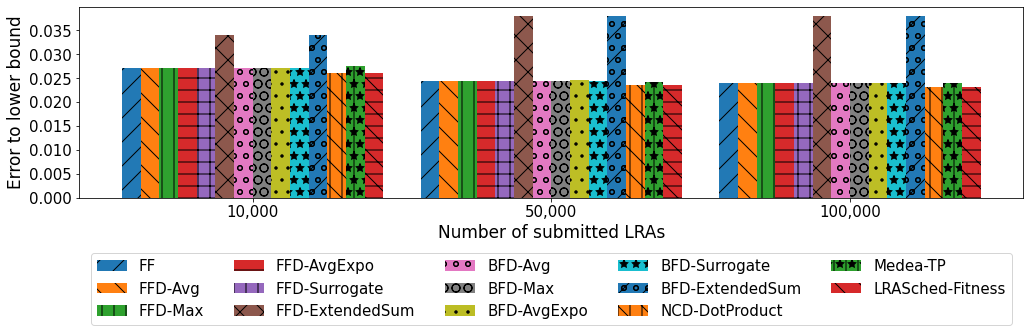

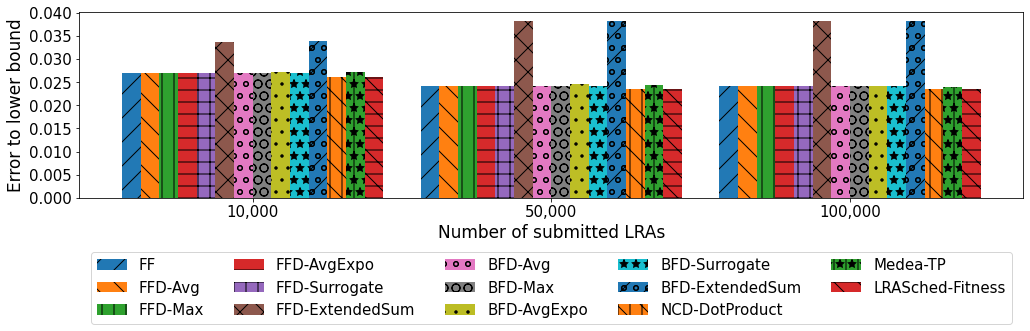

In [99]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(twodim_eps_scale, c, df_2d_large_column_names, "Number of submitted LRAs",
                        'Error to lower bound')    
    filename = f"{proj_path}/plots/large2D_result_{c}.pdf" 
    fig.savefig(filename)

In [20]:
twodim_time_scale[twodim_time_scale['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,BFD-AvgExpo,BFD-Surrogate,BFD-ExtendedSum,BCD-DotProduct,FFD-Degree,BCD-Fitness
0,arbitrary,10000,2.5290,2.5062,2.5043,2.4838,2.4861,3.0249,3.1865,3.1549,3.5625,3.1638,4.44860,14.94220,2.5137,18.39520
1,arbitrary,50000,82.0864,83.4981,84.8444,85.1800,85.8416,130.7033,134.7310,136.3221,159.6201,134.2088,252.25850,974.07300,83.2241,1237.54903
2,arbitrary,100000,325.8789,331.9851,329.6152,331.2620,331.4506,502.9108,513.3166,512.4450,632.2040,517.0758,900.23141,5064.17657,326.8795,6377.53714


In [21]:
twodim_time_scale[twodim_time_scale['class'] == 'threshold'].sort_values(by='density')

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,BFD-AvgExpo,BFD-Surrogate,BFD-ExtendedSum,BCD-DotProduct,FFD-Degree,BCD-Fitness
6,threshold,10000,2.3146,2.3254,2.3184,2.3176,2.3121,2.7616,2.9147,2.9072,3.2960,2.9273,4.0359,12.70400,2.4497,15.52120
7,threshold,50000,61.1581,61.9257,61.7976,61.9833,60.3730,76.8674,90.0752,92.2938,109.5791,91.2435,155.2414,575.76020,67.4533,746.80330
8,threshold,100000,285.0328,281.0873,285.8988,285.0730,301.5077,397.8892,446.4992,441.0202,541.9529,432.7395,686.2282,2988.26279,327.0683,3902.85819


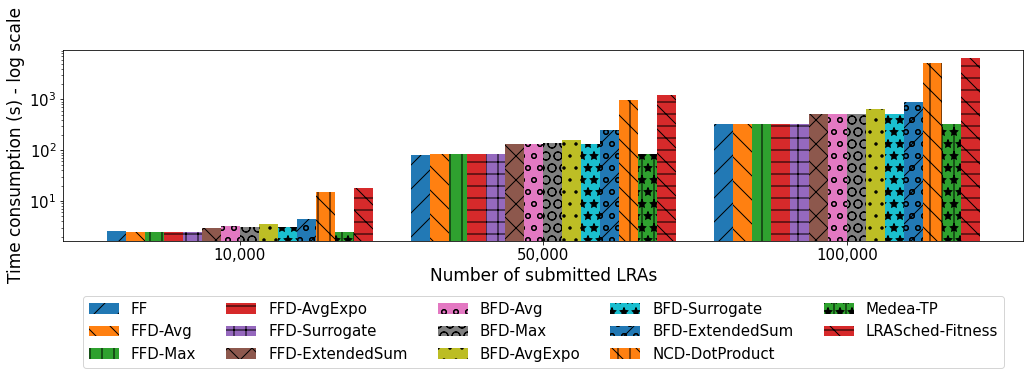

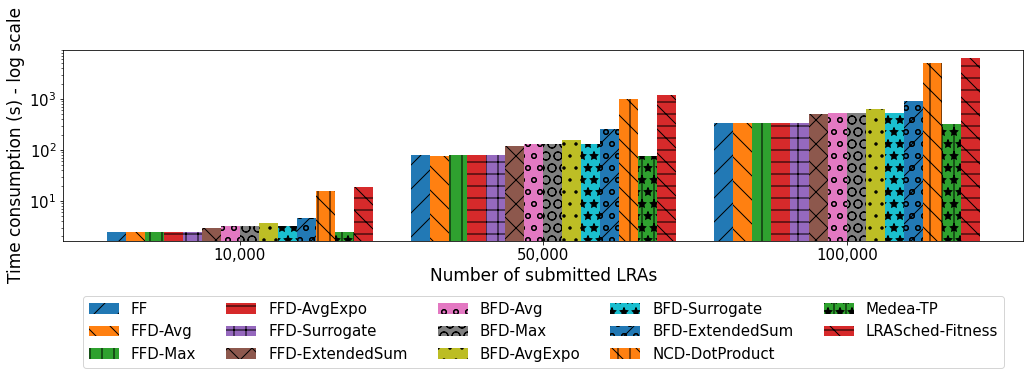

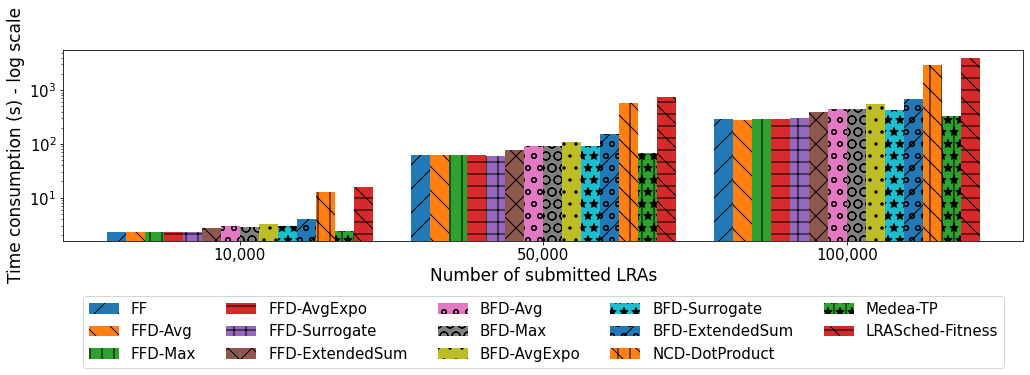

In [100]:
for c in classes: 
#c = "arbitrary"
#fig = plot_scale_barchart(twodim_time_scale, c, df_2d_large_column_names, 'Time consumption (s)')
    fig = plot_barchart(twodim_time_scale, c, df_2d_large_column_names, "Number of submitted LRAs",
                        'Time consumption (s) - log scale', True)

    filename = f"{proj_path}/plots/large2D_time_{c}.pdf" 
    fig.savefig(filename)

# Result-2: Time-Varying Res Request

In [23]:
df_ts = pd.read_csv(file_ts, sep='\t')
ts_eps, ts_time = get_exp_results(df_ts, df_ts_large_column_names)
ts_eps.columns = ['class', 'density'] + df_ts_large_column_names
ts_time.columns = ['class', 'density'] + df_ts_large_column_names

## 2.1 Impact of Affinity Density On Effectiveness and Time Consumption

In [24]:
ts_eps[ts_eps['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,BFD-Avg,FFD-Degree
0,arbitrary,1,0.1042,0.0881,0.0918,0.1005
1,arbitrary,5,0.1025,0.0891,0.0921,0.0993
2,arbitrary,10,0.1004,0.0930,0.0944,0.0991


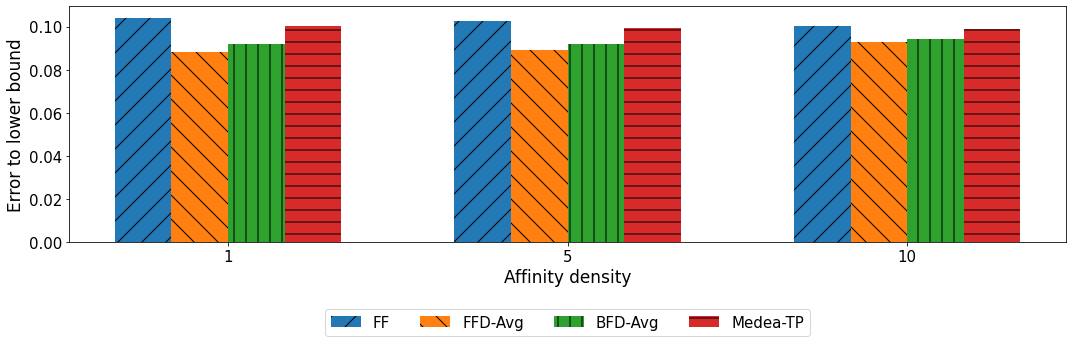

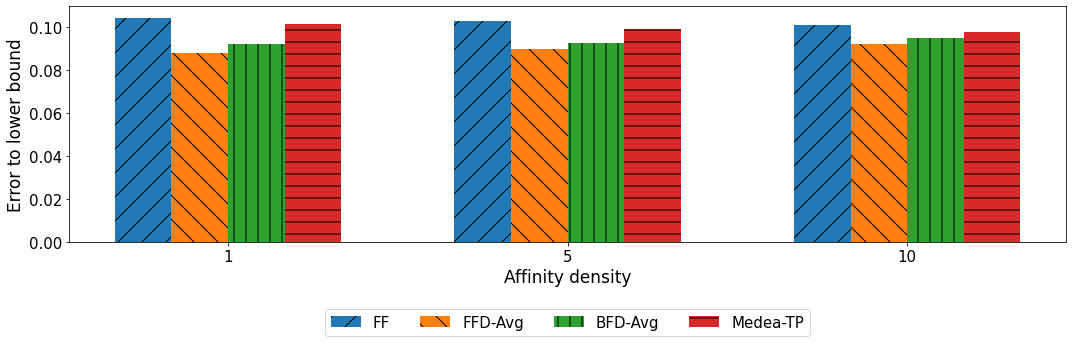

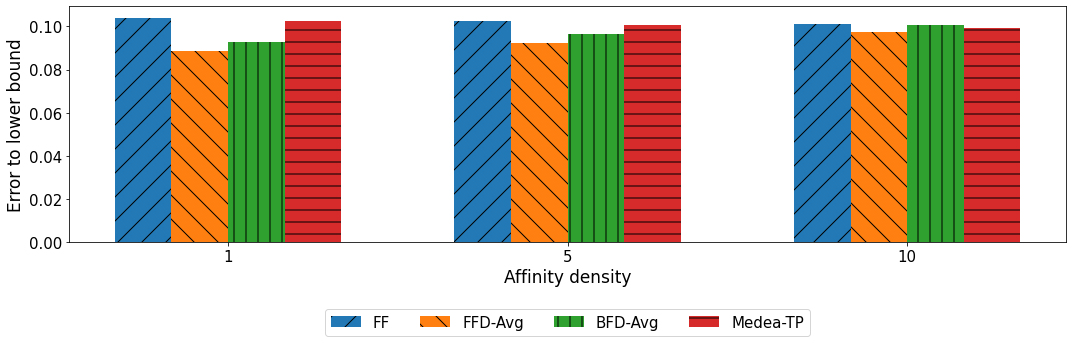

In [101]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(ts_eps, c, df_ts_large_column_names, "Affinity density", 'Error to lower bound')

    filename = f"{proj_path}/plots/densityTS_result_{c}.pdf" 
    fig.savefig(filename)

In [26]:
ts_time[ts_time['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,BFD-Avg,FFD-Degree
0,arbitrary,1,10.6013,14.8218,15.7682,10.1912
1,arbitrary,5,24.6851,29.6145,31.2466,24.1882
2,arbitrary,10,40.6140,47.0340,47.1078,40.3515


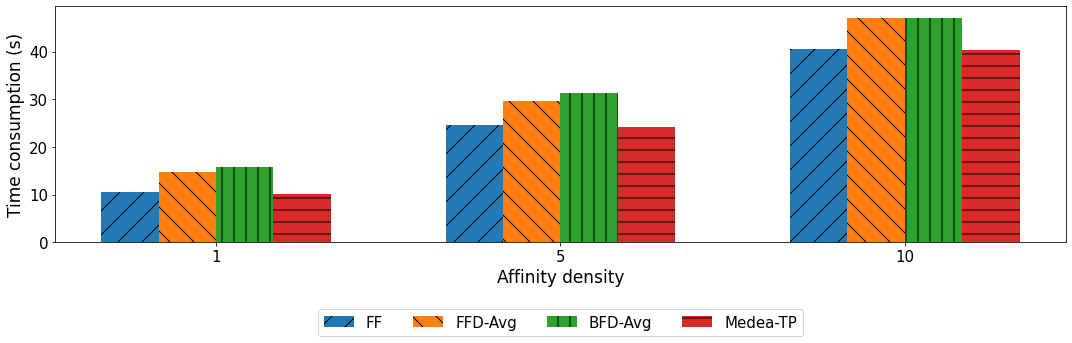

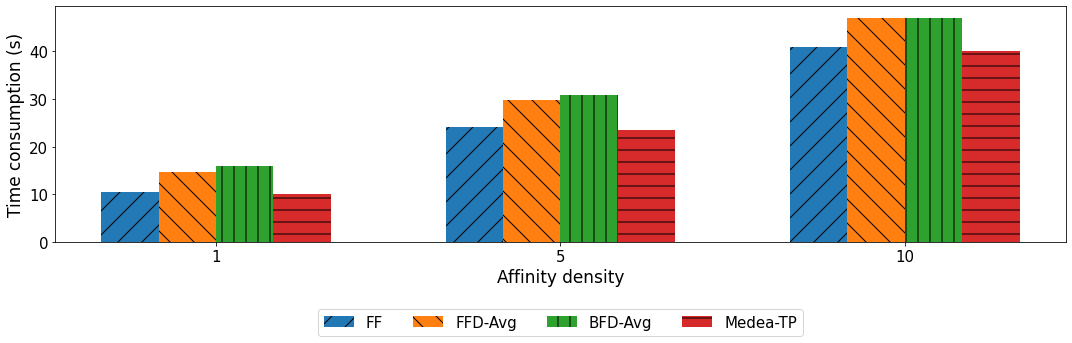

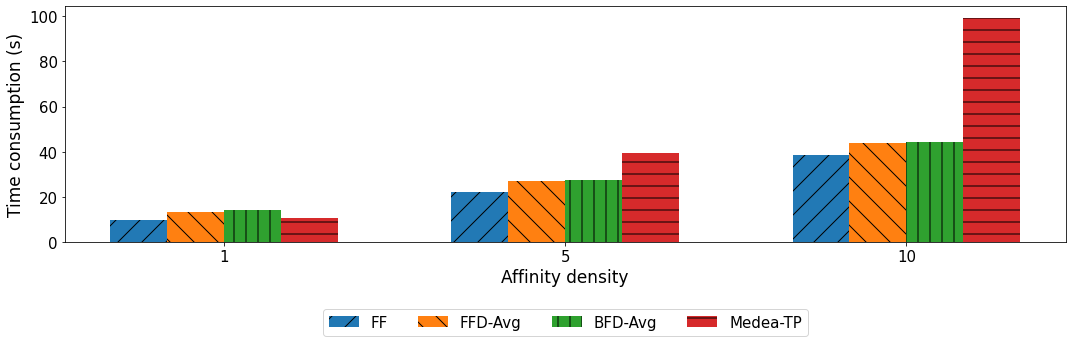

In [102]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(ts_time, c, df_ts_large_column_names, "Affinity density", 'Time consumption (s)')

    filename = f"{proj_path}/plots/densityTS_time_{c}.pdf" 
    fig.savefig(filename)

## 2.2 Impact of LRA Submission Scale On Effectiveness and Time Consumption

In [28]:
df_large_ts = pd.read_csv(file_largeTS, sep='\t') ## df_TS_large

ts_eps_scale, ts_time_scale = get_scale_exp_results(df_large_ts, df_ts_large_column_names)
ts_eps_scale.columns = ['class', 'density'] + df_ts_large_column_names
ts_time_scale.columns = ['class', 'density'] + df_ts_large_column_names

In [29]:
ts_eps_scale[ts_eps_scale['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,BFD-Avg,FFD-Degree
0,arbitrary,10000,0.0535,0.0484,0.0486,0.0534
1,arbitrary,50000,0.0593,0.0569,0.0566,0.0596
2,arbitrary,100000,0.0611,0.0593,0.0593,0.0610


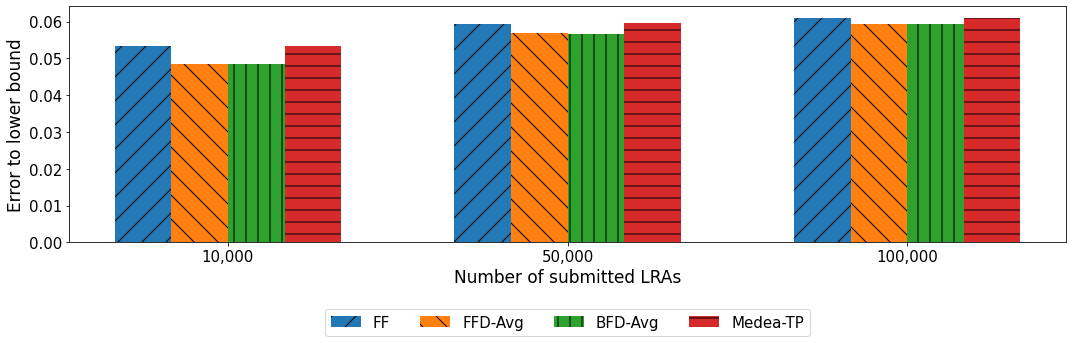

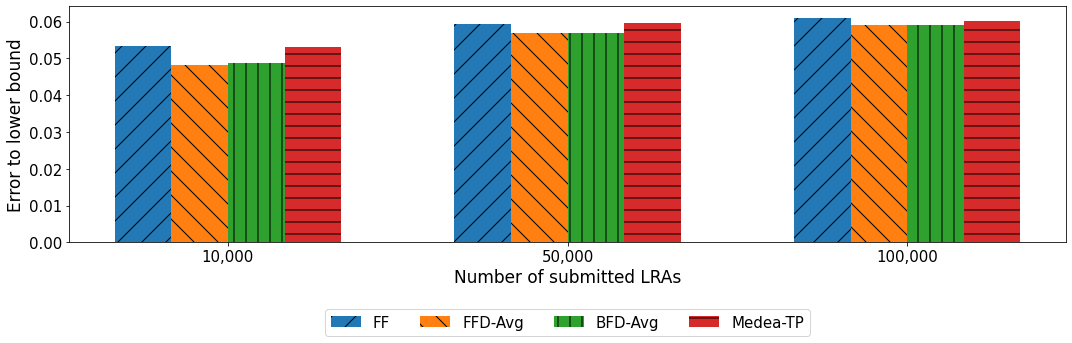

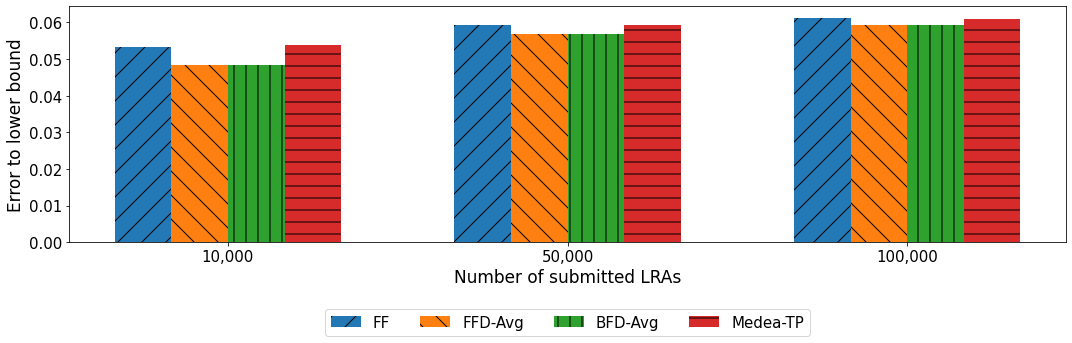

In [103]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(ts_eps_scale, c, df_ts_large_column_names, "Number of submitted LRAs", 'Error to lower bound')    
    filename = f"{proj_path}/plots/largeTS_result_{c}.pdf" 
    fig.savefig(filename)

In [31]:
ts_time_scale[ts_time_scale['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,BFD-Avg,FFD-Degree
0,arbitrary,10000,5.4079,5.4637,6.1670,5.27680
1,arbitrary,50000,212.9288,228.2361,268.6106,215.57380
2,arbitrary,100000,963.0881,1035.4934,1286.4603,965.86741


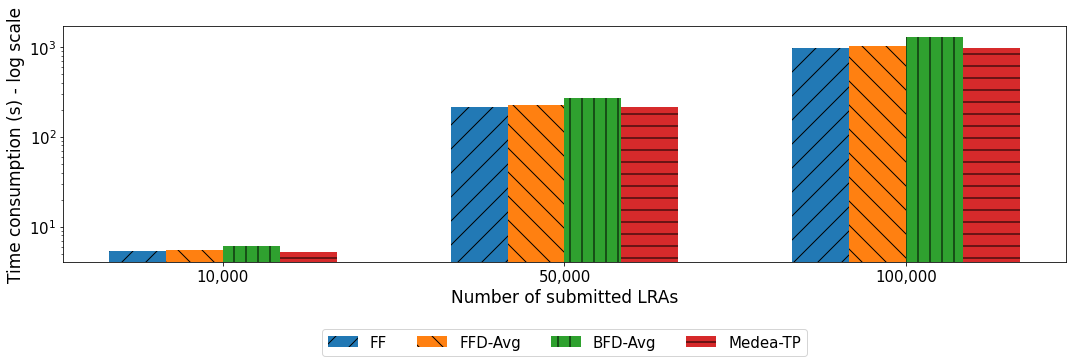

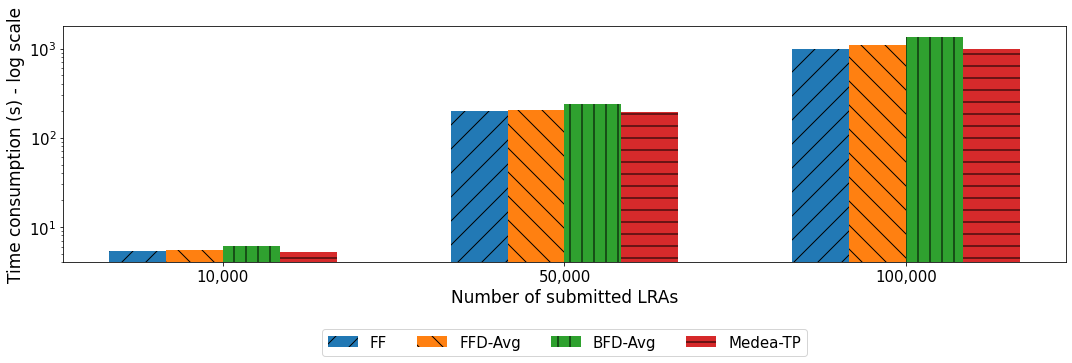

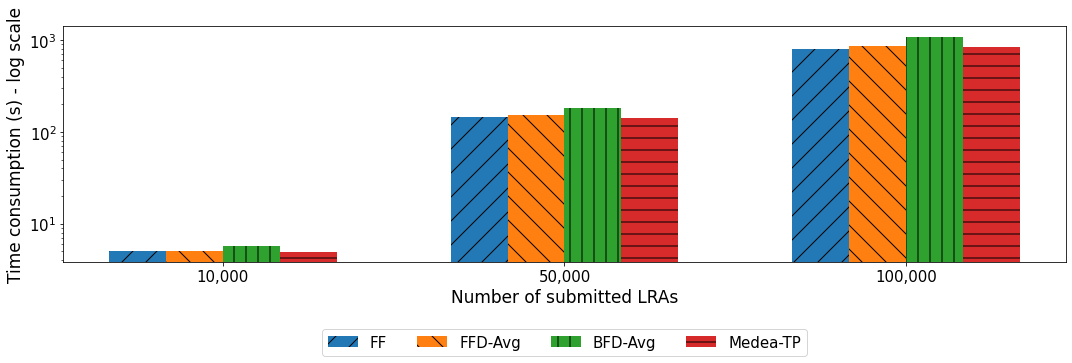

In [104]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(ts_time_scale, c, df_ts_large_column_names, "Number of submitted LRAs",
                        'Time consumption (s) - log scale', True)

    filename = f"{proj_path}/plots/largeTS_time_{c}.pdf" 
    fig.savefig(filename)

# Result-3: Scalability with Varying Res Request

In [33]:
def get_scalability_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[2])
    sub_df['LRAnum'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[1]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = round(sub_df[i]/sub_df['LB'] - 1, 3)
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    df_eps = sub_df[['class', 'LRAnum'] + epsilon_column_names]
    df_time = sub_df[['class', 'LRAnum'] + time_column_names]
    return df_eps, df_time

In [34]:
df_scalab = pd.read_csv(file_scalabilityTS, sep='\t')
scalab_eps, scalab_time = get_scalability_exp_results(df_scalab, df_scalab_column_names)
scalab_eps.columns = ['class', 'density'] + df_scalab_column_names
scalab_time.columns = ['class', 'density'] + df_scalab_column_names

In [35]:
scalab_eps[scalab_eps['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,BFD-Avg,FFD-Degree
0,arbitrary,10000,0.056,0.054,0.054,0.055
3,arbitrary,20000,0.065,0.061,0.060,0.061
6,arbitrary,30000,0.058,0.052,0.052,0.058
9,arbitrary,40000,0.062,0.058,0.058,0.068
12,arbitrary,50000,0.059,0.056,0.056,0.058
15,arbitrary,60000,0.056,0.052,0.052,0.056
18,arbitrary,70000,0.061,0.059,0.060,0.061
21,arbitrary,80000,0.059,0.055,0.055,0.059
24,arbitrary,90000,0.056,0.055,0.055,0.057
27,arbitrary,100000,0.059,0.059,0.059,0.059


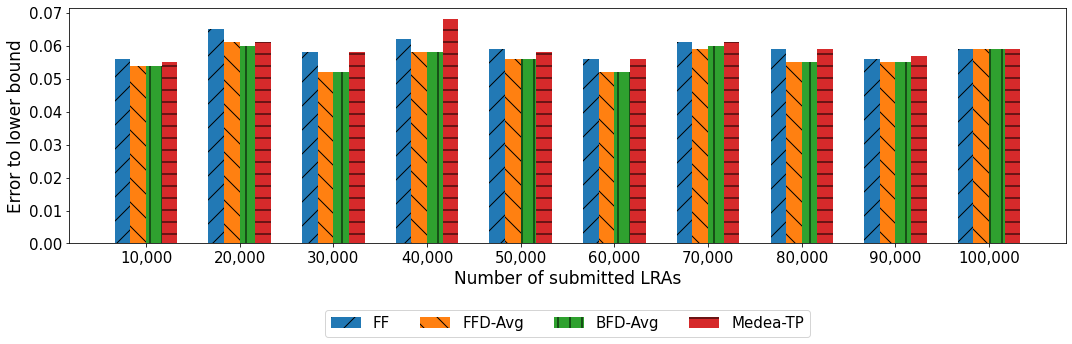

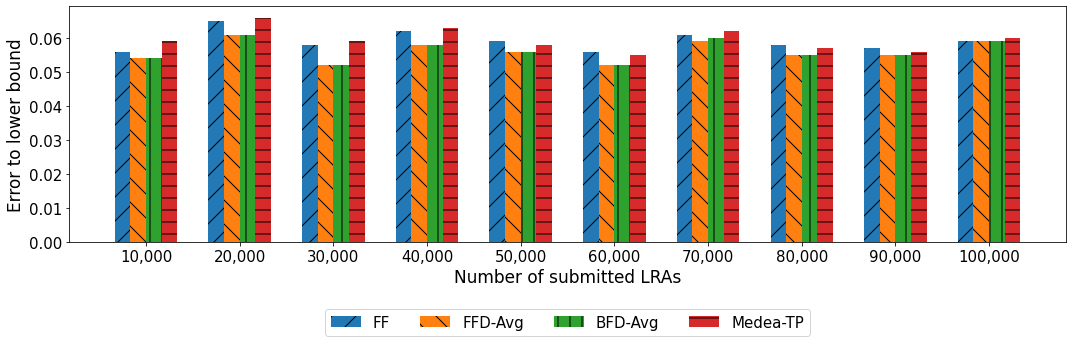

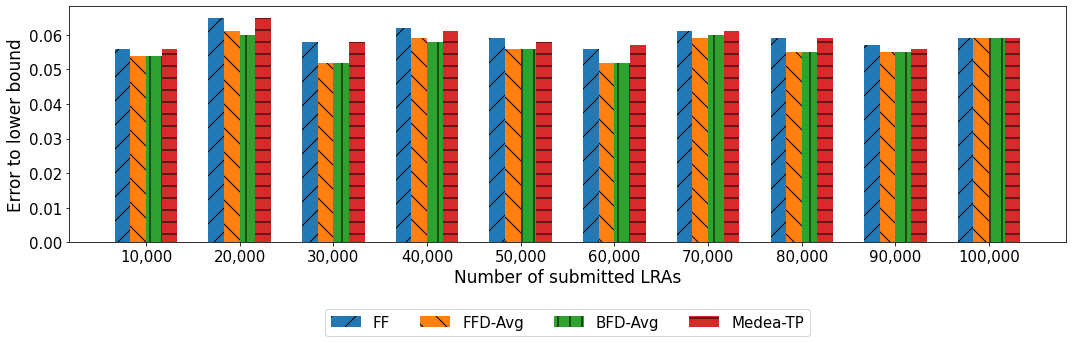

In [105]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(scalab_eps, c, df_scalab_column_names, "Number of submitted LRAs", 'Error to lower bound')    
    filename = f"{proj_path}/plots/scalabilityTS_result_{c}.pdf" 
    fig.savefig(filename)

In [37]:
scalab_time[scalab_time['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,BFD-Avg,FFD-Degree
0,arbitrary,10000,4.243,9.725,12.366,4.556
3,arbitrary,20000,60.612,60.125,68.598,60.182
6,arbitrary,30000,97.086,97.589,113.608,96.306
9,arbitrary,40000,187.225,187.978,221.180,179.219
12,arbitrary,50000,275.805,277.453,328.986,272.970
15,arbitrary,60000,390.853,400.911,479.626,388.166
18,arbitrary,70000,557.904,572.322,689.591,567.453
21,arbitrary,80000,737.540,733.013,889.931,732.867
24,arbitrary,90000,887.948,891.088,1090.752,871.906
27,arbitrary,100000,1114.787,1146.088,1386.874,1111.071


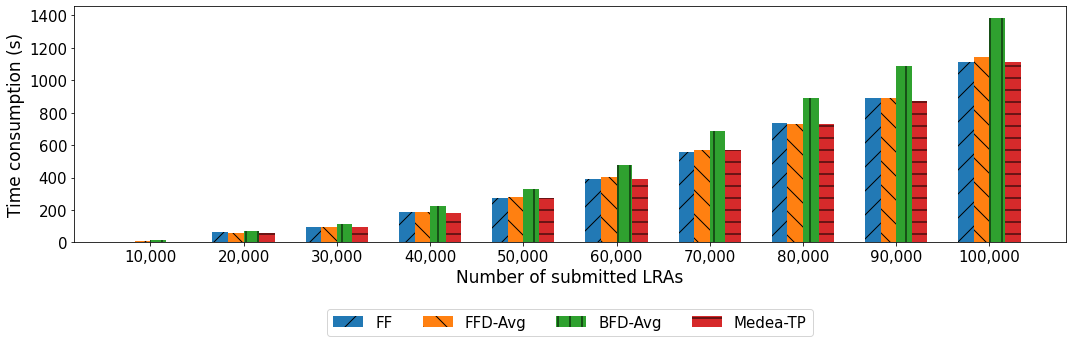

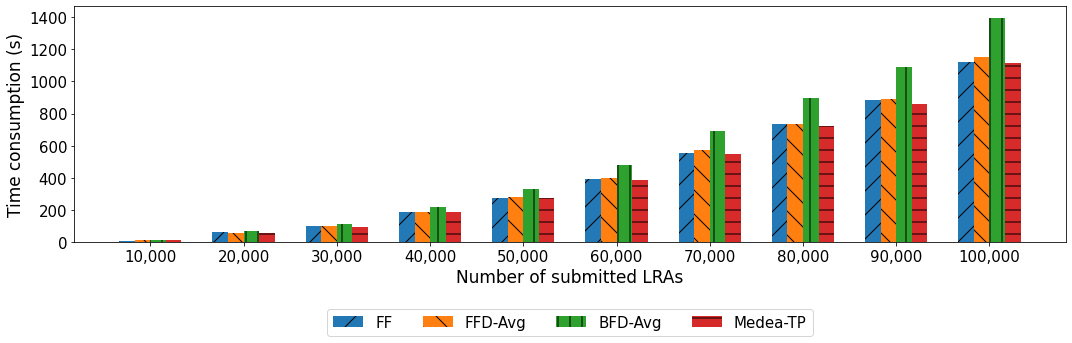

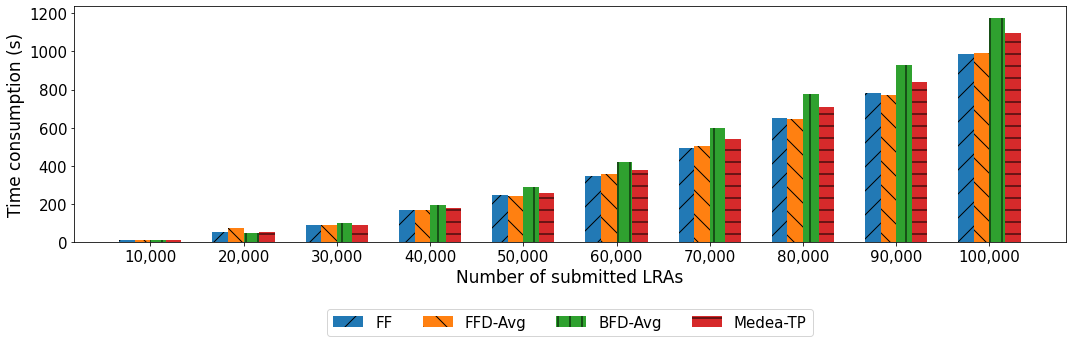

In [106]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(scalab_time, c, df_scalab_column_names, "Number of submitted LRAs", 'Time consumption (s)')

    filename = f"{proj_path}/plots/scalabilityTS_time_{c}.pdf" 
    fig.savefig(filename)

# Result-4: Scheduling per Batch with Varying Res Request

In [39]:
df_batch = pd.read_csv(file_batchTS, sep='\t')
batch_eps, batch_time = get_exp_results(df_batch, df_batch_column_names)
batch_eps.columns = ['class', 'density'] + df_batch_column_names
batch_time.columns = ['class', 'density'] + df_batch_column_names

In [40]:
batch_eps[batch_eps['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,BFD-Avg,BCD-DotProduct,FFD-Degree,BCD-Fitness
0,arbitrary,1,0.1042,0.1211,0.1213,0.1377,0.1024,0.1366
1,arbitrary,5,0.1025,0.1196,0.1201,0.1496,0.1005,0.1488
2,arbitrary,10,0.1004,0.1178,0.1188,0.1599,0.0995,0.1605


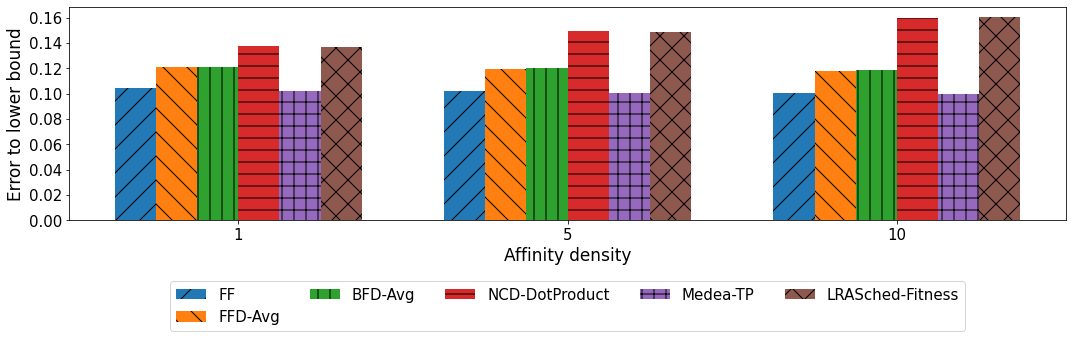

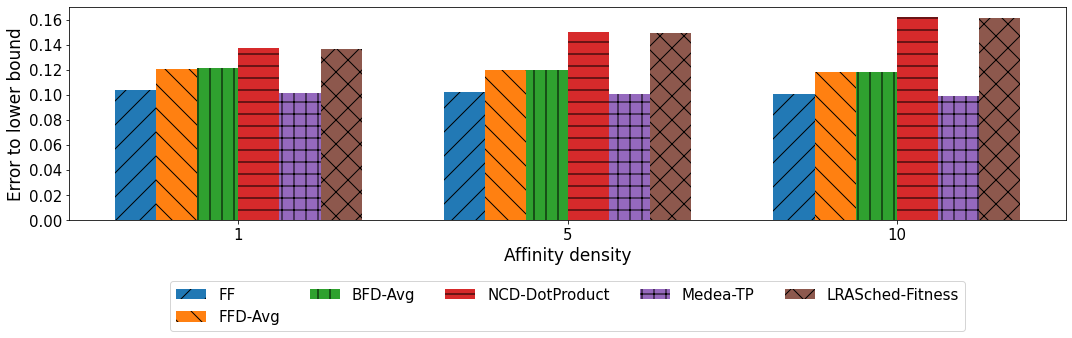

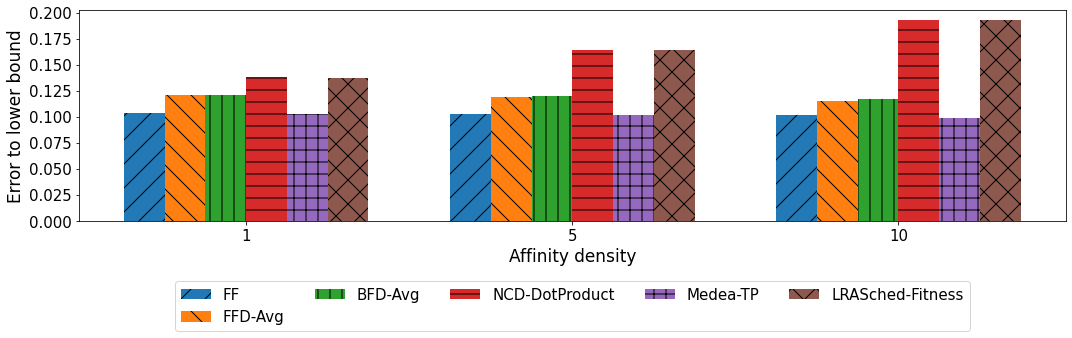

In [107]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(batch_eps, c, df_batch_column_names, "Affinity density", 'Error to lower bound')

    filename = f"{proj_path}/plots/batchTS_result_{c}.pdf" 
    fig.savefig(filename)

In [42]:
batch_time[batch_time['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,BFD-Avg,BCD-DotProduct,FFD-Degree,BCD-Fitness
0,arbitrary,1,15.1146,15.2852,18.7373,18.0680,14.8943,933.0828
1,arbitrary,5,31.1402,31.2529,33.3123,31.3635,30.8672,980.3766
2,arbitrary,10,56.0929,56.6181,54.7653,58.1965,55.0989,1038.7130


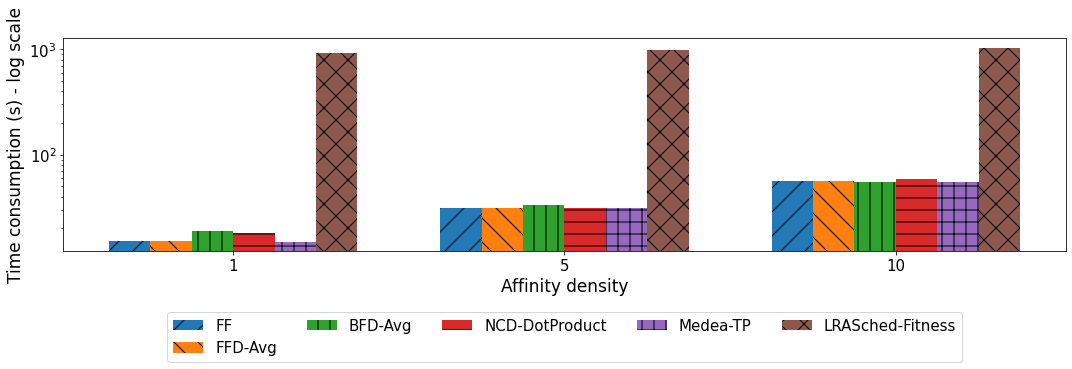

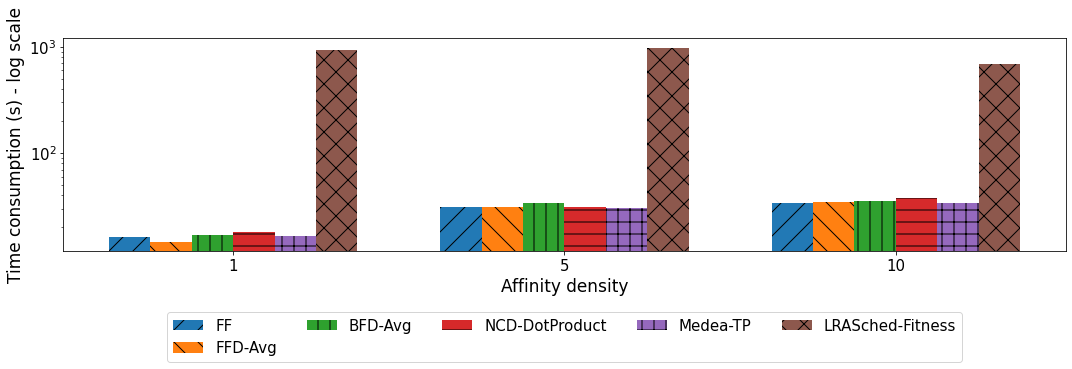

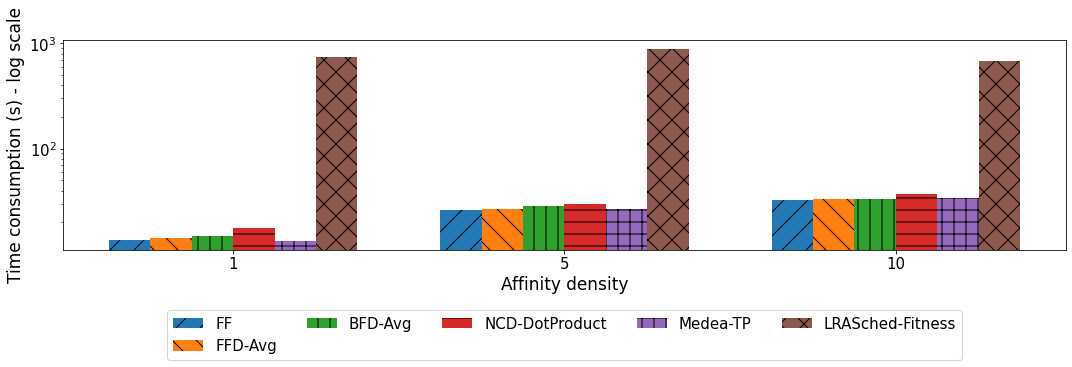

In [108]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(batch_time, c, df_batch_column_names, "Affinity density",
                        'Time consumption (s) - log scale', True)

    filename = f"{proj_path}/plots/batchTS_time_{c}.pdf" 
    fig.savefig(filename)